In [4]:
import sys 
sys.path.append('codes')
from scipy.optimize import curve_fit
import MyFunctions as mf
import matplotlib.pyplot as plt
import rixs_tools as rt

import numpy as np
from scipy.signal import convolve

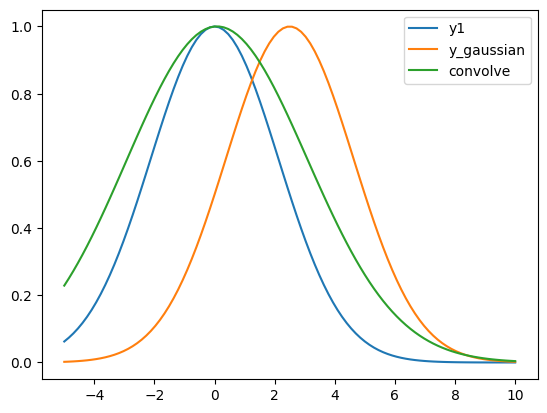

In [12]:
#test convolve function in scipy.signal
#convolve two gaussian function
x = np.linspace(-5, 10, 100)
x_gaussian = np.linspace(-7.5, 7.5, 100)
y1 = mf.fun_gaussian(x, 0, 1, 5)
y2 = mf.fun_gaussian(x_gaussian, 0, 1, 5)
y = convolve(y1, y2, mode='same', method='auto')
y = y/max(y)
plt.plot(x, y1, label='y1')
plt.plot(x, y2, label='y_gaussian')
plt.plot(x, y, label='convolve')
plt.legend()

## Note
1. remove elastic peaks first
2. fit the inelastic signal 


In [4]:
def fun_total(x, x_elastic, A_elastic, res, mu,\
              A_s, Delta, Gamma, T,\
              x_phonon1, A_phonon1, res_phonon1,\
                x_phonon2, A_phonon2, res_phonon2,\
                    x_background, A_background, res_background, q):
    y_elastic = fun_pvoigt(x, x_elastic, A_elastic, res, mu)
    y_s = fun_s(x, A_s, Delta, Gamma, T, q)
    y_phonon1 = fun_pvoigt(x, x_phonon1, A_phonon1, res_phonon1, mu)
    y_phonon2 = fun_pvoigt(x, x_phonon2, A_phonon2, res_phonon2, mu)
    y_background = fun_pvoigt(x, x_background, A_background, res_background, mu)
    return y_elastic + y_s + y_phonon1 + y_phonon2 + y_background

def fun_s(x, A, Delta, Gamma, T, q):
    def chi(q, omega, q_cdw, Delta, Gamma):
        c = 255
        temp = 1 / (Delta**2 + c**2 * (q - q_cdw)**2 - (omega + 1j*Gamma)**2)
        norm = 1/2 * 1 / np.sqrt(Delta**2 + c**2 * (q - q_cdw)**2)
        return temp * norm

    def S(q_array, Omega_array, q_cdw, Delta, Gamma, T):
        if np.isscalar(q_array):
            chi_array = chi(q_array, Omega_array, q_cdw, Delta, Gamma)
            return 1000 * 2 / (1 - np.exp(-Omega_array/T)) * np.imag(chi_array)
        else:
            q_mesh, Omega_mesh = np.meshgrid(q_array, Omega_array)
            chi_mesh = chi(q_mesh, Omega_mesh, q_cdw, Delta, Gamma)
            return 1000 * 2 / (1 - np.exp(-Omega_mesh/T)) * np.imag(chi_mesh)

    return A * S(q, x, 0.235, Delta, Gamma, T)

def convoluted_fun_s(x, A, Delta, Gamma, T, q):
    # Calculate sigma from FWHM
    def gaussian(x, mu, sigma):
        return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

    fwhm = 1
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    
    # Generate a range for the Gaussian, centered at 0 with some width
    x_gaussian = np.linspace(-3*sigma, 3*sigma, 100)
    gaussian_curve = gaussian(x_gaussian, 0, sigma)
    
    # Calculate fun_s for a range of x values
    fun_s_values = fun_s(x, A, Delta, Gamma, T, q)
    
    # Convolute fun_s with the Gaussian
    # Assume x is a numpy array for simplicity; adjust as necessary for your case
    convoluted_values = convolve(fun_s_values, gaussian_curve, mode='same')
    
    return convoluted_values

def fun_loren(x, x0, A, res):
    return A * (res/2)**2 / ((x - x0)**2 + (res/2)**2)

def fun_gauss(x, x0, A, res):
    k = res / 2
    sigma = k / (np.sqrt(2) * np.sqrt(np.log(2)))
    return A * np.exp(-(x - x0)**2 / (2 * sigma**2))

def fun_pvoigt(x, x0, A, res, mu):
    return mu * fun_loren(x, x0, A, res) + (1 - mu) * fun_gauss(x, x0, A, res)


In [1]:
# First attempt


temperatures_char = ['T21','T62','T104','T155']
temperatures = np.array([21, 62, 104, 155])*0.086


As = 48.9124
mus = 0.22
qs = np.array([0.05, 0.1, 0.15, 0.18, 0.2, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.287])
num = np.size(qs)
deltas = dict(T21= np.zeros(np.size(qs)), T62= np.zeros(np.size(qs)), T104= np.zeros(np.size(qs)), T155= np.zeros(np.size(qs)))
gammas = dict(T21= np.zeros(np.size(qs)), T62= np.zeros(np.size(qs)), T104= np.zeros(np.size(qs)), T155= np.zeros(np.size(qs)))
As = dict(T21= np.zeros(np.size(qs)), T62= np.zeros(np.size(qs)), T104= np.zeros(np.size(qs)), T155= np.zeros(np.size(qs)))
deltas_error = dict(T21= np.zeros(np.size(qs)), T62= np.zeros(np.size(qs)), T104= np.zeros(np.size(qs)), T155= np.zeros(np.size(qs)))
gammas_error = dict(T21= np.zeros(np.size(qs)), T62= np.zeros(np.size(qs)), T104= np.zeros(np.size(qs)), T155= np.zeros(np.size(qs)))
As_error = dict(T21= np.zeros(np.size(qs)), T62= np.zeros(np.size(qs)), T104= np.zeros(np.size(qs)), T155= np.zeros(np.size(qs)))
fig, axes = plt.subplots(4,4 , figsize=(20, 18))
fig2, axes2 = plt.subplots(4,4 , figsize=(20, 18))
x_phonon2 = np.zeros(np.size(qs))


for i,temperature in enumerate(temperatures_char):
    temperature_char = temperatures_char[i]
    temperature = temperatures[i]
    Ttemp = np.genfromtxt(('simulation_data/'+temperature_char+'.csv'), delimiter=',')  
    Ttemp_sub = np.ones(np.shape(Ttemp))*1000

    for j,q in enumerate(qs):
        # subtract the elastic peak
        if j != 5 and j != 6 and j!=7 and j!=8:
            continue
        x_min = -100
        x_max = 5
        x = Ttemp[:,2*j]
        y = Ttemp[:,2*j+1]
        y = y[(x>x_min) & (x<x_max)]
        x = x[(x>x_min) & (x<x_max)]
        # Fit the data with the Voigt profile
        def wrapper_fv(x, a, b):
            c = 17.2  # Fixed value for the third parameter
            d = 8.2  # Fixed value for the fourth parameter
            return mf.fv(x, a, b, c, d)
        popt, pcov = curve_fit(wrapper_fv, x, y , p0=[0, 10])
        # Extracting the parameters
        x0, A = popt
        Ttemp_sub[:,2*j] = Ttemp[:,2*j]
        Ttemp_sub[:,2*j+1] = Ttemp[:,2*j+1] - wrapper_fv(Ttemp[:,2*j], *popt)

        # plot the fitting and data to axes2
        if j == 5 or j == 6 or j==7 or j==8:
            x_plot = np.linspace(x_min, x_max, 100)
            ax = axes2[i,j-5]
            ax.plot(x_plot, wrapper_fv(x_plot, *popt), 'r-', label='fit') 
            ax.plot(x, y, '.', label='data')
            # add to the plot the fG and fL parameters of the fitting, keep up to 1 digit
            #ax.text(0.05, 0.95, 'fG = '+str(np.round(fG,1))+'\nfL = '+str(np.round(fL,1)), #transform=ax.transAxes, fontsize=14, verticalalignment='top')
            ax.set_ylim([0, 2])

        # fit the data with fun_total
        x_min = -50
        x_max = 220
        x = Ttemp[:,2*j]
        y = Ttemp_sub[:,2*j+1]
        y = y[(x>x_min) & (x<x_max)]
        x = x[(x>x_min) & (x<x_max)]
        # x, x_elastic, A_elastic, res, mu,\
        #               A_s, Delta, Gamma, T,\
        #               x_phonon1, A_phonon1, res_phonon1\
        #               x_phonon2, A_phonon2, res_phonon2\
        #               x_background, A_background, res_background, q
        epsilon = 0.001
        parameters_guess = [0, 0, 22.5, mus,\
                            11, 10, 15, temperature ,\
                            50, 1, 22.5,\
                            80, 3, 22.5,\
                            150, 0.1, 200, q]
        lower_bounds = [-5, 0-epsilon, 22.5-epsilon, mus-epsilon,\
                            11-epsilon, 0, 0, temperature-epsilon ,\
                            45, 0, 22,\
                            65, 0, 22,\
                            50, 0, 80, q-epsilon]
        upper_bounds = [5, 0, 22.5, mus,\
                            11, 50, 50, temperature ,\
                            65, 10, 23,\
                            100, 10,23,\
                            1000, 10, 1000, q]
        # increase the weight of the data of x>0
        weight = np.ones(np.size(x))
        weight[(x<5)&(x>100)] = 0.1
        popt, pcov = curve_fit(fun_total, x, y, p0=parameters_guess, bounds=(lower_bounds, upper_bounds), sigma=weight)
        

        deltas[temperature_char][j] = popt[5]
        gammas[temperature_char][j] = popt[6]
        As[temperature_char][j] = popt[4]
        # save gamma error to gammas_error
        gammas_error[temperature_char][j] = np.sqrt(np.diag(pcov))[6]
        deltas_error[temperature_char][j] = np.sqrt(np.diag(pcov))[5]
        As_error[temperature_char][j] = np.sqrt(np.diag(pcov))[4]
        if j == 5 or j == 6 or j==7 or j==8:
            x_plot = np.linspace(x_min, x_max, 100)
            ax = axes[i,j-5]
            ax.plot(x_plot, fun_total(x_plot, *popt), 'r-', label='fit') 
            # plot shaded curve
            ax.fill_between(x_plot, fun_pvoigt(x_plot, popt[14], popt[15], popt[16], popt[3]), color='lightgrey') 
            ax.fill_between(x_plot, fun_pvoigt(x_plot, popt[0], popt[1], popt[2], popt[3]), color='lightgrey')
            ax.fill_between(x_plot, fun_pvoigt(x_plot, popt[8], popt[9], popt[10], popt[3]), color='lightblue')
            ax.fill_between(x_plot, fun_pvoigt(x_plot, popt[11], popt[12], popt[13], popt[3]), color='lightgreen')  
            # plot fun_s, shaded curve
            ax.fill_between(x_plot, fun_s(x_plot, popt[4], popt[5], popt[6], popt[7], popt[-1]), color='lightcoral') 
            # plot background, shaded curve
            ax.plot(x, y, '.', label='data')
            if j == 5:  # Only for the left-most column
                ax.set_ylabel('Intensity (arb. units)')
            if i == 3:  # Only for the bottom row
                ax.set_xlabel('Energy transfer (meV)')
            # create labels
            ax.set_title(temperature_char+', q = '+str(qs[j]))
            ax.set_xlim([-30,100])
            ax.set_ylim([0, 2.4])
# save figure of axes1
fig.savefig('fitting_results.jpg', dpi=300, bbox_inches='tight')
# save figure of axes2
fig2.savefig('elastics.jpg', dpi=300, bbox_inches='tight')


NameError: name 'np' is not defined

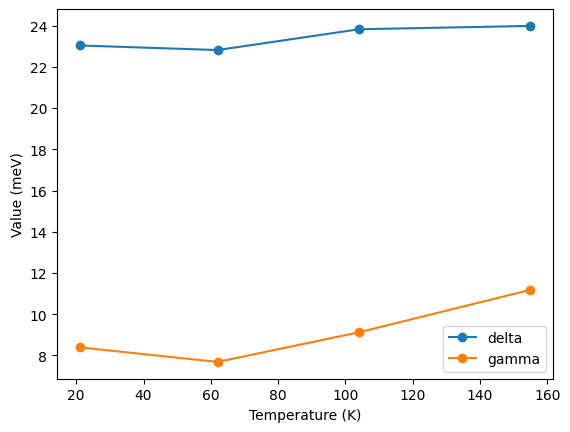

In [13]:
plt.plot([21,62,104,155],[deltas['T21'][6], deltas['T62'][6], deltas['T104'][6], deltas['T155'][6]], 'o-', label='delta')
plt.plot([21,62,104,155],[gammas['T21'][6], gammas['T62'][6], gammas['T104'][6], gammas['T155'][6]], 'o-', label='gamma')
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('Value (meV)')

#save figure
plt.savefig('delta_gamma_vs_temperature', dpi=300, bbox_inches='tight')


In [122]:
deltas


{'T21': array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        15.55091561, 15.85961628, 18.53057285, 18.07242967,  0.        ,
         0.        ,  0.        ,  0.        ]),
 'T62': array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        19.79908553, 20.42862247, 20.61180064, 20.05212614,  0.        ,
         0.        ,  0.        ,  0.        ]),
 'T104': array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        24.72649869, 25.63752328, 24.27764963, 22.09779965,  0.        ,
         0.        ,  0.        ,  0.        ]),
 'T155': array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        28.50705304, 30.37484279, 29.57170491, 28.96924759,  0.        ,
         0.        ,  0.        ,  0.        ])}

FileNotFoundError: C:/Users/51910/OneDrive/1UZH/2Projects/lesco/fitting_method2/T21.csv not found.

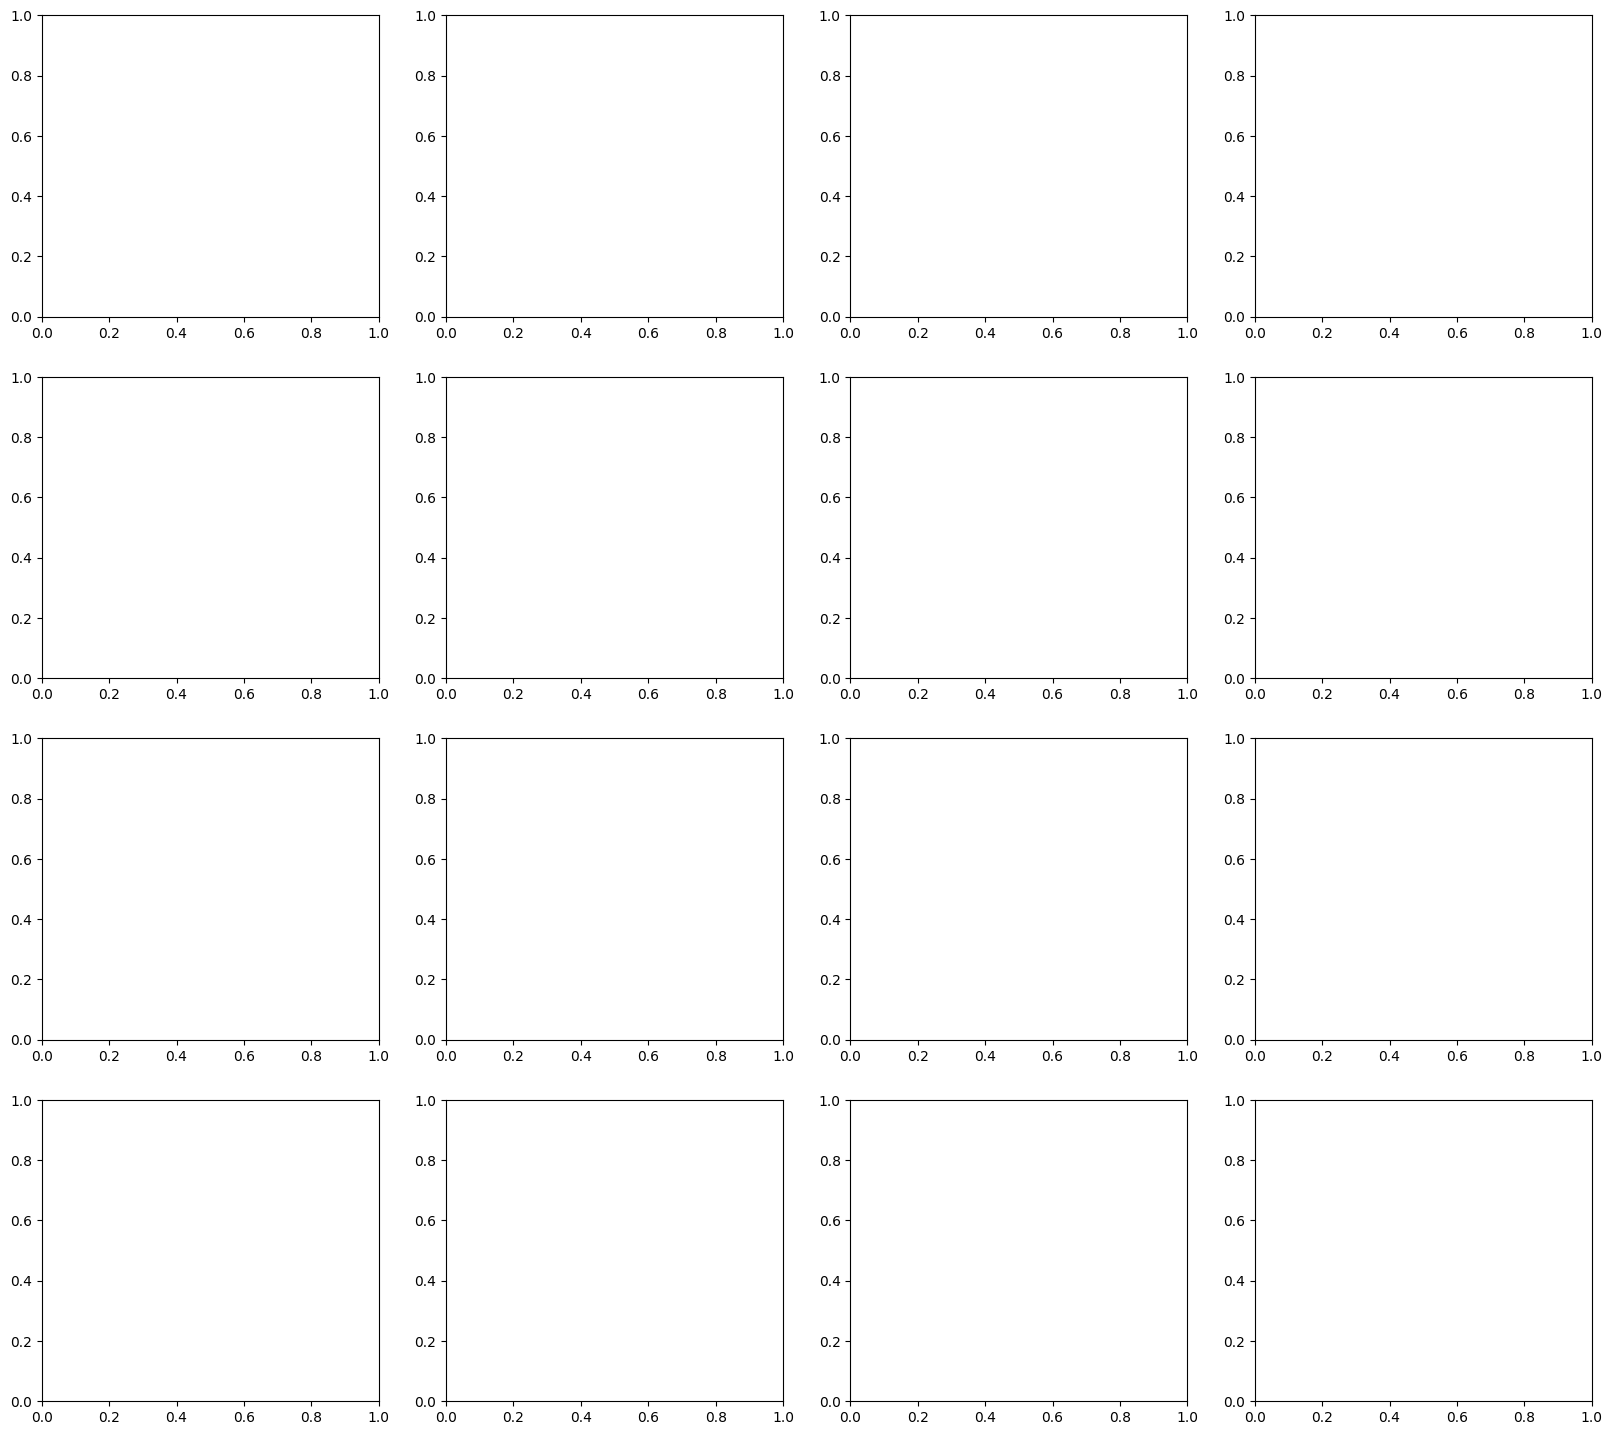

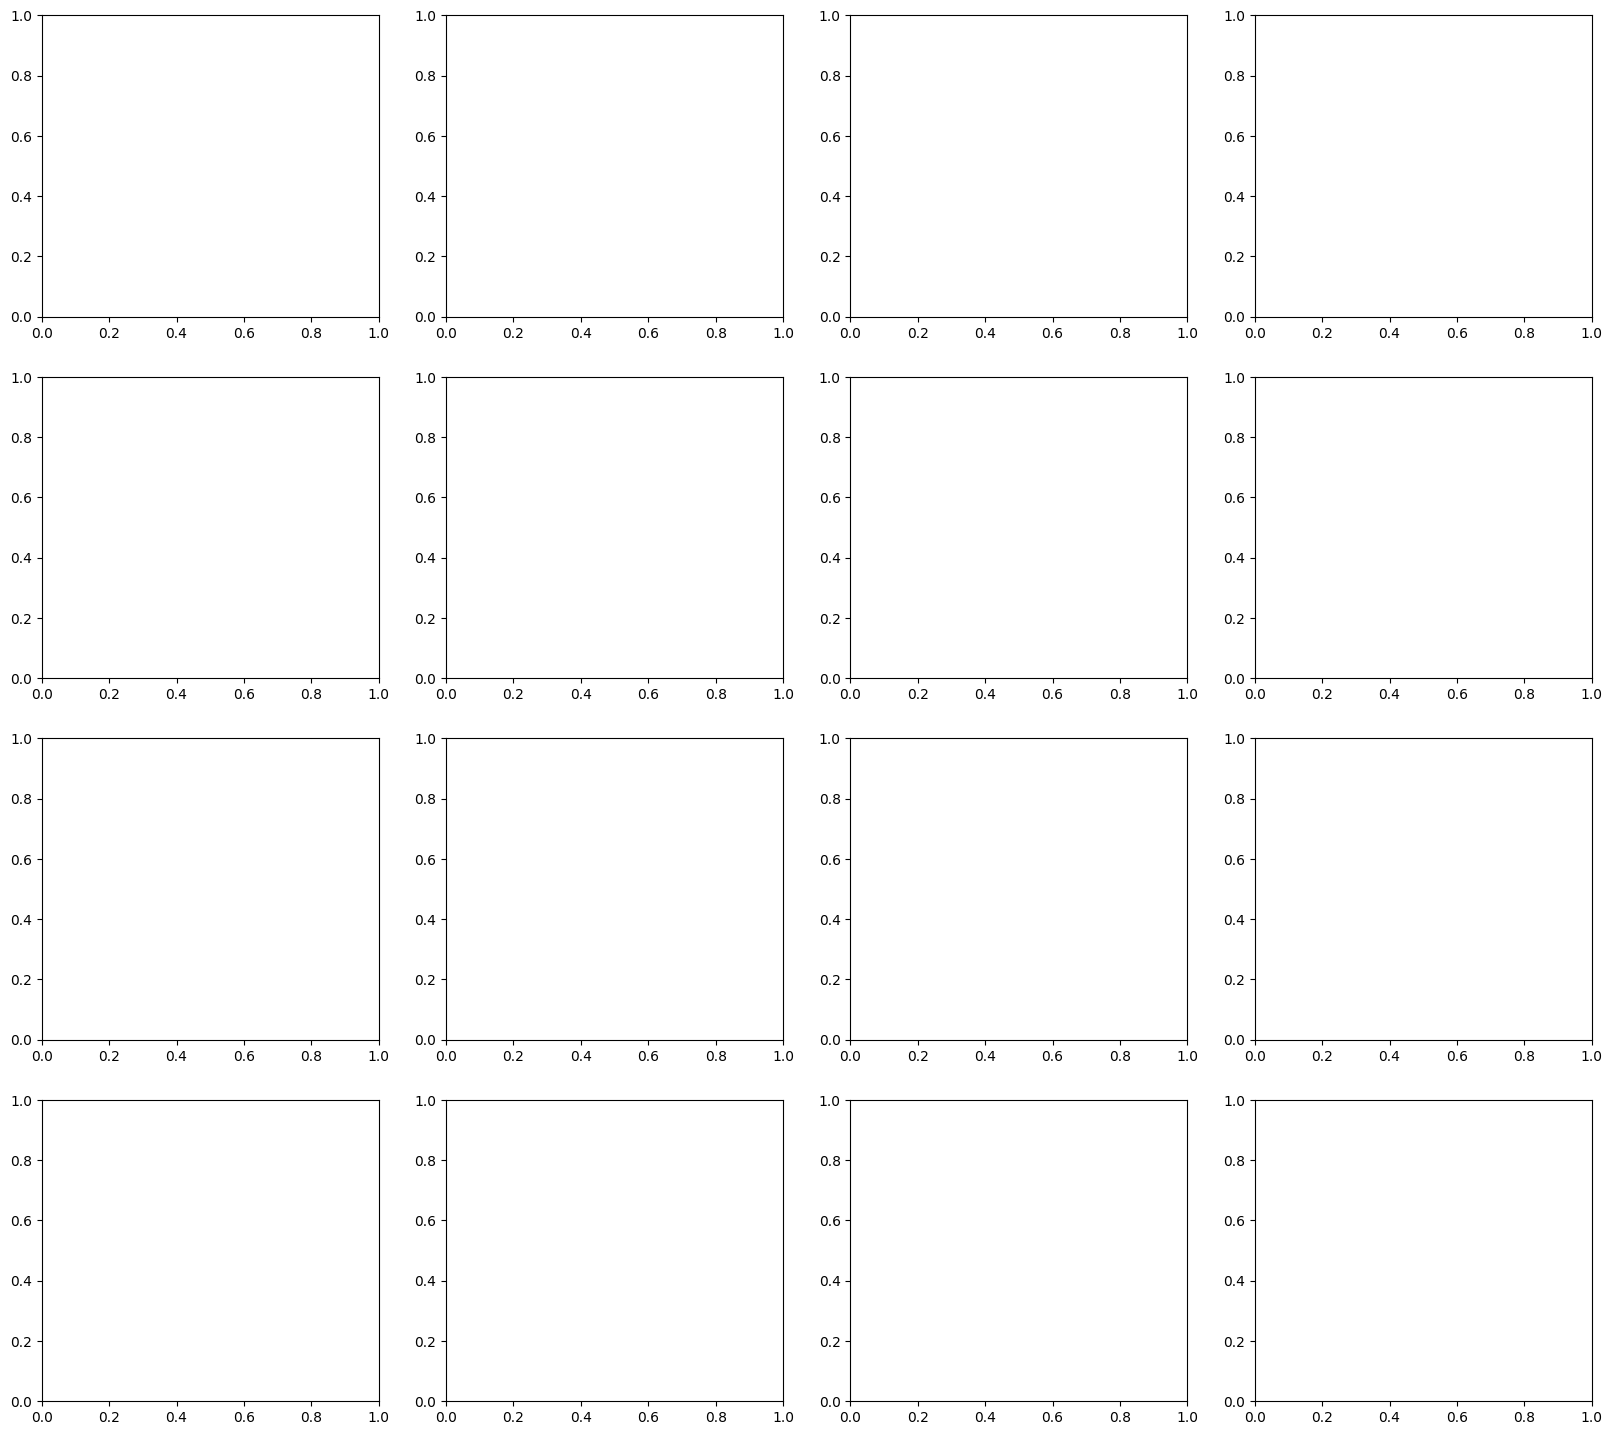

In [91]:

temperatures_char = ['T21', 'T62', 'T104', 'T155']
temperatures = np.array([21, 62, 104, 155])*0.086
As = [54.9653,   48.9124,   37.0336,   22.8117]
mus = [0.3,0.22,0.4,0.4]
qs = np.array([0.05, 0.1, 0.15, 0.18, 0.2, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.287])
num = np.size(qs)
deltas = dict(T21= np.zeros(np.size(qs)), T62= np.zeros(np.size(qs)), T104= np.zeros(np.size(qs)), T155= np.zeros(np.size(qs)))
gammas = dict(T21= np.zeros(np.size(qs)), T62= np.zeros(np.size(qs)), T104= np.zeros(np.size(qs)), T155= np.zeros(np.size(qs)))
As = dict(T21= np.zeros(np.size(qs)), T62= np.zeros(np.size(qs)), T104= np.zeros(np.size(qs)), T155= np.zeros(np.size(qs)))
deltas_error = dict(T21= np.zeros(np.size(qs)), T62= np.zeros(np.size(qs)), T104= np.zeros(np.size(qs)), T155= np.zeros(np.size(qs)))
gammas_error = dict(T21= np.zeros(np.size(qs)), T62= np.zeros(np.size(qs)), T104= np.zeros(np.size(qs)), T155= np.zeros(np.size(qs)))
As_error = dict(T21= np.zeros(np.size(qs)), T62= np.zeros(np.size(qs)), T104= np.zeros(np.size(qs)), T155= np.zeros(np.size(qs)))
fig, axes = plt.subplots(4,4 , figsize=(20, 18))
fig, axes2 = plt.subplots(4,4 , figsize=(20, 18))

# declear x_phonon 2 



for i,temperature in enumerate(temperatures_char):
    Ttemp = np.genfromtxt(('C:/Users/51910/OneDrive/1UZH/2Projects/lesco/fitting_method2/'+temperature+'.csv'), delimiter=',')  
    Ttemp_sub = np.ones(np.shape(Ttemp))*1000

    for j,q in enumerate(qs):
        # subtract the elastic peak
        if j != 5 and j != 6 and j!=7 and j!=8:
            continue
        x_min = -100
        x_max = 5
        x = Ttemp[:,2*j]
        y = Ttemp[:,2*j+1]
        y = y[(x>x_min) & (x<x_max)]
        x = x[(x>x_min) & (x<x_max)]
        # Fit the data with the Voigt profile
        popt, pcov = curve_fit(mf.fv, x, y , p0=[0, 10, 10, 10])
        # Extracting the parameters
        x0, A, fG, fL = popt
        Ttemp_sub[:,2*j] = Ttemp[:,2*j]
        Ttemp_sub[:,2*j+1] = Ttemp[:,2*j+1] - mf.fv(Ttemp[:,2*j], *popt)
    
        # plot the fitting and data to axes2
        if j == 5 or j == 6 or j==7 or j==8:
            x_plot = np.linspace(x_min, x_max, 100)
            ax = axes2[i,j-5]
            ax.plot(x_plot, mf.fv(x_plot, *popt), 'r-', label='fit') 
            ax.plot(x, y, '.', label='data')
            # add to the plot the fG and fL parameters of the fitting, keep up to 1 digit
            ax.text(0.05, 0.95, 'fG = '+str(np.round(fG,1))+'\nfL = '+str(np.round(fL,1)), transform=ax.transAxes, fontsize=14, verticalalignment='top')
            ax.set_ylim([0, 2])

        # fit the data with fun_total
        x_min = -50
        x_max = 170
        x = Ttemp[:,2*j]
        y = Ttemp_sub[:,2*j+1]
        y = y[(x>x_min) & (x<x_max)]
        x = x[(x>x_min) & (x<x_max)]
        # x, x_elastic, A_elastic, res, mu,\
        #               A_s, Delta, Gamma, T,\
        #               x_phonon1, A_phonon1, res_phonon1\
        #               x_phonon2, A_phonon2, res_phonon2\
        #               x_background, A_background, res_background
        epsilon = 0.001
        parameters_guess = [0, 0, 22.5, mus[i],\
                            3, 20, 20, temperatures[i] ,\
                            50, 1, 22.5,\
                            80, 3, 22.5,\
                            150, 0.1, 200]
        lower_bounds = [-5, 0-epsilon, 22.5-epsilon, mus[i]-epsilon,\
                            0, 0, 0, temperatures[i]-epsilon ,\
                            45, 0, 22,\
                            65, 0, 22,\
                            50, 0, 80]
        upper_bounds = [5, 0, 22.5, mus[i],\
                            30, 100, 100, temperatures[i] ,\
                            65, 10, 23,\
                            100, 10,23,\
                            1000, 10, 1000]
        # increase the weight of the data of x>0
        weight = np.ones(np.size(x))
        weight[x>0] = 1.5
        popt, pcov = curve_fit(fun_total, x, y, p0=parameters_guess, bounds=(lower_bounds, upper_bounds), sigma=weight)
        

        deltas[temperature][j] = popt[5]
        gammas[temperature][j] = popt[6]
        As[temperature][j] = popt[4]
        # save gamma error to gammas_error
        gammas_error[temperature][j] = np.sqrt(np.diag(pcov))[6]
        deltas_error[temperature][j] = np.sqrt(np.diag(pcov))[5]
        As_error[temperature][j] = np.sqrt(np.diag(pcov))[4]
        if j == 5 or j == 6 or j==7 or j==8:
            x_plot = np.linspace(x_min, x_max, 100)
            ax = axes[i,j-5]
            ax.plot(x_plot, fun_total(x_plot, *popt), 'r-', label='fit') 
            # plot shaded curve
            ax.fill_between(x_plot, fun_pvoigt(x_plot, popt[14], popt[15], popt[16], popt[3]), color='lightgrey') 
            ax.fill_between(x_plot, fun_pvoigt(x_plot, popt[0], popt[1], popt[2], popt[3]), color='lightgrey')
            ax.fill_between(x_plot, fun_pvoigt(x_plot, popt[8], popt[9], popt[10], popt[3]), color='lightblue')
            ax.fill_between(x_plot, fun_pvoigt(x_plot, popt[11], popt[12], popt[13], popt[3]), color='lightgreen')  
            # plot fun_s, shaded curve
            ax.fill_between(x_plot, fun_s(x_plot, popt[4], popt[5], popt[6], popt[7]), color='lightcoral') 
            # plot background, shaded curve
            ax.plot(x, y, '.', label='data')
            if j == 5:  # Only for the left-most column
                ax.set_ylabel('Intensity (arb. units)')
            if i == 3:  # Only for the bottom row
                ax.set_xlabel('Energy transfer (meV)')
            # create labels
            ax.set_title(temperatures_char[i]+', q = '+str(qs[j]))



## Plot deltas
# Select the deltas at q=0.22, q=0.23, q=0.24, and q=0.25
delta_q022 = np.array([deltas['T21'][5], deltas['T62'][5], deltas['T104'][5], deltas['T155'][5]])
delta_q023 = np.array([deltas['T21'][6], deltas['T62'][6], deltas['T104'][6], deltas['T155'][6]])
delta_q024 = np.array([deltas['T21'][7], deltas['T62'][7], deltas['T104'][7], deltas['T155'][7]])
delta_q025 = np.array([deltas['T21'][8], deltas['T62'][8], deltas['T104'][8], deltas['T155'][8]])
# Select the error bars at q=0.22, q=0.23, q=0.24, and q=0.25
delta_q022_error = np.array([deltas_error['T21'][5], deltas_error['T62'][5], deltas_error['T104'][5], deltas_error['T155'][5]])
delta_q023_error = np.array([deltas_error['T21'][6], deltas_error['T62'][6], deltas_error['T104'][6], deltas_error['T155'][6]])
delta_q024_error = np.array([deltas_error['T21'][7], deltas_error['T62'][7], deltas_error['T104'][7], deltas_error['T155'][7]])
delta_q025_error = np.array([deltas_error['T21'][8], deltas_error['T62'][8], deltas_error['T104'][8], deltas_error['T155'][8]])

# Plot the deltas as a function of temperature with error bars
fig, axes = plt.subplots(1,2,figsize=(9, 3))
ax = axes[0]
ax.errorbar(temperatures, delta_q022, yerr=delta_q022_error, fmt='mo-', label='q = 0.22')
ax.errorbar(temperatures, delta_q023, yerr=delta_q023_error, fmt='ro-', label='q = 0.23')
ax.errorbar(temperatures, delta_q024, yerr=delta_q024_error, fmt='bo-', label='q = 0.24')
ax.errorbar(temperatures, delta_q025, yerr=delta_q025_error, fmt='go-', label='q = 0.25')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Delta')
ax.legend()
ax.set_title('Delta at q=0.22/0.23/0.24/0.25')
ax.set_ylim([0, 30])

ax = axes[1]
ax.errorbar(temperatures/0.086, (delta_q022+delta_q023+delta_q024+delta_q025)/4, yerr=np.sqrt(delta_q022_error**2+delta_q023_error**2+delta_q024_error**2+delta_q025_error**2), fmt='ro-', label='mean value')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Delta')
ax.legend()
ax.set_title('average Delta at q=0.22/0.23/0.24/0.25')
ax.set_ylim([0, 30])
plt.show()

## plot gammas
# Select the gammas at q=0.22, q=0.23, q=0.24, and q=0.25
gamma_q022 = np.array([gammas['T21'][5], gammas['T62'][5], gammas['T104'][5], gammas['T155'][5]])
gamma_q023 = np.array([gammas['T21'][6], gammas['T62'][6], gammas['T104'][6], gammas['T155'][6]])
gamma_q024 = np.array([gammas['T21'][7], gammas['T62'][7], gammas['T104'][7], gammas['T155'][7]])
gamma_q025 = np.array([gammas['T21'][8], gammas['T62'][8], gammas['T104'][8], gammas['T155'][8]])
# Select the error bars at q=0.22, q=0.23, q=0.24, and q=0.25
gamma_q022_error = np.array([gammas_error['T21'][5], gammas_error['T62'][5], gammas_error['T104'][5], gammas_error['T155'][5]])
gamma_q023_error = np.array([gammas_error['T21'][6], gammas_error['T62'][6], gammas_error['T104'][6], gammas_error['T155'][6]])
gamma_q024_error = np.array([gammas_error['T21'][7], gammas_error['T62'][7], gammas_error['T104'][7], gammas_error['T155'][7]])
gamma_q025_error = np.array([gammas_error['T21'][8], gammas_error['T62'][8], gammas_error['T104'][8], gammas_error['T155'][8]])


# Plot the gammas as a function of temperature with error bars
fig, axes = plt.subplots(1,2,figsize=(9, 3))
ax = axes[0]
ax.errorbar(temperatures/0.086, gamma_q022, yerr=gamma_q022_error, fmt='mo-', label='q = 0.22')
ax.errorbar(temperatures/0.086, gamma_q023, yerr=gamma_q023_error, fmt='ro-', label='q = 0.23')
ax.errorbar(temperatures/0.086, gamma_q024, yerr=gamma_q024_error, fmt='bo-', label='q = 0.24')
ax.errorbar(temperatures/0.086, gamma_q025, yerr=gamma_q025_error, fmt='go-', label='q = 0.25')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Gamma')
ax.legend()
ax.set_title('Gamma at q=0.22/0.23/0.24/0.25')
ax.set_ylim([0, 30])
ax = axes[1]
ax.errorbar(temperatures/0.086, (gamma_q022+gamma_q023+gamma_q024+gamma_q025)/4, yerr=np.sqrt(gamma_q022_error**2+gamma_q023_error**2+gamma_q024_error**2+gamma_q025_error**2), fmt='ro-', label='mean value')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Gamma')
ax.legend()
ax.set_title('average Gamma at q=0.22/0.23/0.24/0.25')
ax.set_ylim([0, 30])
plt.show()



In [ ]:
x_phonon2

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       70.58712784, 69.90369181, 69.24324743, 70.13093728,  0.        ,
        0.        ,  0.        ,  0.        ])

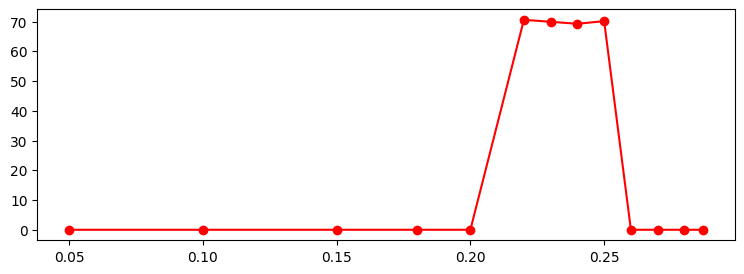

In [ ]:
# plot x_phonon 2
fig, axes = plt.subplots(1,1,figsize=(9, 3))
ax = axes
ax.plot(qs, x_phonon2, 'ro-', label='fit')

In [ ]:
import numpy as np

# Create numpy arrays for gammas and deltas at 0.23/0.24/0.25
gamma_q023 = np.array([gammas['T21'][6], gammas['T62'][6], gammas['T104'][6], gammas['T155'][6]])
gamma_q024 = np.array([gammas['T21'][7], gammas['T62'][7], gammas['T104'][7], gammas['T155'][7]])
gamma_q025 = np.array([gammas['T21'][8], gammas['T62'][8], gammas['T104'][8], gammas['T155'][8]])

delta_q023 = np.array([deltas['T21'][6], deltas['T62'][6], deltas['T104'][6], deltas['T155'][6]])
delta_q024 = np.array([deltas['T21'][7], deltas['T62'][7], deltas['T104'][7], deltas['T155'][7]])
delta_q025 = np.array([deltas['T21'][8], deltas['T62'][8], deltas['T104'][8], deltas['T155'][8]])

# Create numpy array for temperatures
temperatures = np.array([21, 62, 104, 155])

# Stack the gammas and deltas arrays vertically
data = np.vstack((temperatures, gamma_q023, gamma_q024, gamma_q025, delta_q023, delta_q024, delta_q025))

# Save the stacked array to a CSV file
np.savetxt('gammas_deltas.csv', data, delimiter=',')
